In [1]:
import os
import numpy as np
from random import shuffle
import csv
import pickle
#from dictionaries import d_words_g
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import random
from pathlib import Path
import pdb
import gensim
import json
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Embedding, LSTM, Dense, concatenate
from keras.models import Model, Sequential, load_model
from keras.layers.wrappers import TimeDistributed

Using TensorFlow backend.


In [2]:
def get_one_hot(sentence_list):
    # Get unique words and make one hot vectors of them
    unique_words = []
    for sentence in sentence_list:
        for w in sentence:
            unique_words.append(w)
    unique_words = list(set(unique_words))
    unique_words.append('ENDW')
    unique_words.append('ENDS')
    unique_words.append('NONE')
    # Now get one hot vectors of these unique words, store in unique_dict
    unique_dict = {}
    for ind,w in enumerate(unique_words):
        unique_dict[w] = np.eye(len(unique_words))[ind]
    return unique_dict

In [3]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=200):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """
    #pdb.set_trace()
    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)
    np.mean(unit_vectors)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    units_ps = np.array(units_ps)
    mean_ps = np.mean(units_ps, axis=0)
    return freq, mean_ps, units_ps

In [11]:
def plot_results(plot_path, freq, power,sampling_rate=200,n_samples=60,title='Input stimuli',smoothed=True):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    # Build plot
    plt.title(title)
    hz_4 = np.where(freq == 4)[0][0]
    plt.plot(freq[1:hz_4+5], power[1:hz_4+5], 'r', linewidth=1.0)
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Power (db)')
    # Adjusts subplot
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    #plt.plot()
    plt.savefig(plot_path+'.pdf')
    plt.pause(0.05)

    return


In [5]:
def windowed_zscores(vals,window=10):
    scores = np.zeros(vals.shape)
    seq_length = vals.shape[0]
    for i in range(seq_length):
        # before window length is reached
        if i < window:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[0:i]]).mean()
        # less than window length remaining
        elif (i + window) > seq_length:
            scores[i] = vals[i] - np.concatenate([vals[i-window:i],vals[i+1:]]).mean()
        # after window length is reached
        else:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[i-window:i]]).mean()
    return scores

In [6]:
def create_sentences(SenType = 'sen'):
    # possible sentypes: 
    # sen:          regular sentence
    # wordlist:     wordlists
    # nongrammar:   grammatically correct, nonsensical
    # nounphrase:   noun phrases
    # verbphrase:   verb phrases
    # random:       adjective noun verb noun random
    
    # Load dictionaries
    base = str(Path(os.getcwd()).parent)
    new_dict = np.load(base + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0] # create 3 different orthogonal vecs to encode gaps,
    new_dict.item()['ENDW'] = np.eye(new_dict.item()['cute'].shape[0])[1] # endw, ends
    new_dict.item()['ENDS'] = np.eye(new_dict.item()['cute'].shape[0])[2]
    
    with open(base + '\\Data\\Ding_grammatical.csv', 'r') as f:
        all_sentences = [row for row in csv.reader(f)]
    nouns, adjectives, verbs = [],[],[]
    for sentence in all_sentences:
        nouns.append(sentence[1])
        nouns.append(sentence[3])
        adjectives.append(sentence[0])
        verbs.append(sentence[2])
    nouns = list(set(nouns))
    adjectives = list(set(adjectives))
    verbs = list(set(verbs))
    all_words = nouns + adjectives + verbs


    N = 60        
    if SenType == 'sen':
        # Load words as lists
        with open(base + '\\Data\\Ding_grammatical.csv', 'r') as f:
            sentence_list = [row for row in csv.reader(f)]
            
    elif SenType == 'wordlist':
        sentence_list = [random.sample(all_words,4) for i in range(N)]
        
    elif SenType == 'nongrammar':   
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(adjectives,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(verbs,1)[0]
            w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'nounphrase':        
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(adjectives,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(adjectives,1)[0]
            w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'verbphrase':
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(verbs,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(verbs,1)[0]
            w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'random':
        sentence_list = list()
        for i in range(N):
            w1 = random.sample(verbs,1)[0]
            w2 = random.sample(nouns,1)[0]
            w3 = random.sample(nouns,1)[0]
            w4 = random.sample(adjectives,1)[0]
            sentence_list.append([w1,w2,w3,w4])   
    # add these pseudo words to all_words now because they only need to appear in repn, not in sequence info itself
    all_words.append('NONE')
    all_words.append('ENDW')
    all_words.append('ENDS')
    embedding_dict = {}
    one_hot_dict = {}
    for ind,key in enumerate(all_words):
        embedding_dict[key] = new_dict.item()[key]
        one_hot_dict[key] = np.eye(len(all_words))[ind]
    return sentence_list, embedding_dict, one_hot_dict

In [7]:
def participants_gen_with_end_SO(repeat_words=False, train_gen=True, withend = True, SenType = 'sen',
                                type_embedding='one_hot'):
    """Generates batches of sentences corresponding to the grammatical condition
    of Ding et all (2016). The Input words correspond to Word2Vec representations
    from Frank & Yang (2018).
   
    Args:
        train_gen: if it is for training (True) or testing (False)
        withend: output has only word endings or also sentence endings.
        repeat_words: if True words in the input sentences are repeated 4 times,
            otherwise filled with 'NONE' 3 times.
        SenType: 
            # sen:          regular sentence
            # wordlist:     wordlists
            # nongrammar:   adjective noun verb noun > grammatically correct, random words
            # nounphrase:   noun phrases
            # verbphrase:   verb phrases
            # random:       verb noun noun adjective
        
        
    Returns:
        A tuple of inputs and labels for training.
    """
    #pdb.set_trace()
    # load the sentences
    sentence_list, embedding_dict, one_hot_dict = create_sentences(SenType=SenType)  
        
    if train_gen == True: # keep selection of sentences apart for testing/training
        sentence_list = sentence_list[0:-13] # 60 - 13 = 47 sentences
        Ntrl = 20
    else:
        sentence_list = sentence_list[-13:]
        Ntrl = 10
    Nsen = len(sentence_list)   # 47 for training
    while True:      
        # Lists to store inputs and labels
        input_batch = []
        output_batch = []
        for ind,sent in enumerate(sentence_list):
            # Repeat words or fill with 'NONE'
            if repeat_words:
                # 50 ms sample time, 20 samples/second
                input_words = [sent[0], sent[0], sent[0], sent[0], sent[0],
                               sent[1], sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2], sent[2],
                               sent[3], sent[3], sent[3], sent[3], sent[3]]                

            else:  # This is needed to get the 4Hz input
                input_words = ['NONE', sent[0], sent[0], sent[0], sent[0],
                               'NONE', sent[1], sent[1], sent[1], sent[1],
                               'NONE', sent[2], sent[2], sent[2], sent[2],
                               'NONE', sent[3], sent[3], sent[3], sent[3]]
                
            if withend:
                output_words = [sent[0], sent[0], sent[0], sent[0], 'NONE',
                                   sent[1], sent[1], sent[1], sent[1], 'NONE',
                                   sent[2], sent[2], sent[2], sent[2], 'NONE',
                                   sent[3], sent[3], sent[3], sent[3], 'ENDS']
            else:
                output_words = [sent[0], sent[0], sent[0], sent[0], 'NONE',
                                   sent[1], sent[1], sent[1], sent[1], 'NONE',
                                   sent[2], sent[2], sent[2], sent[2], 'NONE',
                                   sent[3], sent[3], sent[3], sent[3], 'NONE']
                
                                    
            # Generate one-hot representation of words for output (the model takes as input the indices directly)
            if type_embedding == 'one_hot':
                input_vectors = [one_hot_dict[word] for word in input_words]
            elif type_embedding == 'pretrained':
                input_vectors = [embedding_dict[word] for word in input_words]
            output_vectors = [one_hot_dict[word] for word in output_words]
            
                
            # Append to batch lists
            input_batch.append(input_vectors)
            output_batch.append(output_vectors)
        #pdb.set_trace()
        # in the Ding et al., 2016 they had 12 repetitions of sentences per trial for a total of 22 trials (but we are going to up this)                       
        input_batchT = np.array(input_batch) # shape = 47 x 20 x 300       
        output_batchT = np.array(output_batch).astype(bool)  # shape = 47 x 20 x N (Ndim of one hot encoding)
        
        r = 13 #(then start at random lags)
        usedSenCom = np.zeros([Ntrl,r])+Nsen+1  # Fill a 20 x 13 matrix with 48 everywhere
        input_batchFS = np.zeros([Ntrl,r*input_batchT.shape[1],input_batchT.shape[2]]) # 20 x (260) x 300
        output_batchFS = np.zeros([Ntrl,r*output_batchT.shape[1],output_batchT.shape[2]]) # 20 x (260) x N
        for trl in range(Ntrl):  # (0:20)              
            # check if doesn't exist
            check = False            
            while check==False:
                rp = np.random.permutation(Nsen) # vector of shape 47 x 1 containing randomly arranged elements in (0-47)
                n = 0
                for it in range(r): # (0:13)
                    if rp[it] in usedSenCom[:,it]: # if [random_permutation(0:47)][it] in usedSenCom[:,it]                            
                        n = n + 1
                if n <= r:
                    check = True
            usedSenCom[trl,:] = rp[0:r] # replace trl row with the random permutations
            for it in range(r): # (0:13)             
                input_batchFS[trl,it*20:it*20+20,:] = input_batchT[rp[it],:,:]   
                output_batchFS[trl,it*20:it*20+20,:] = output_batchT[rp[it],:,:]   
        # create all the lags:
        l = 19
        input_batchFS2 = np.zeros([Ntrl*l,240,input_batchT.shape[2]])
        output_batchFS2 = np.zeros([Ntrl*l,240,output_batchT.shape[2]]).astype(bool)
        #output_batch = np.zeros([Ntrl*l, 3])
        for lcnt in range(l):
            input_batchFS2[lcnt*Ntrl:Ntrl*lcnt+Ntrl,:,:] = input_batchFS[:,lcnt:-(l-lcnt)-1,:]
            # in output_batchFS2, the words that have ENDS at their end should not have them if only a part of the 
            # sentence is making an appearance
            # therefore, see to it that if l > 0, the first_batch has its sentence end replaced by a word end
            if lcnt > 0:
                first_batch_index = 19 - lcnt
                temporary_assignment = output_batchFS[:,lcnt:-(l-lcnt)-1,:]
                temporary_assignment[:,first_batch_index,:] = one_hot_dict['NONE']
                output_batchFS2[lcnt*Ntrl:lcnt*Ntrl+Ntrl,:,:] = temporary_assignment
            else:
                output_batchFS2[lcnt*Ntrl:lcnt*Ntrl+Ntrl,:,:] = output_batchFS[:,lcnt:-(l-lcnt)-1,:]
        rp = np.random.permutation(output_batchFS2.shape[0])
        yield input_batchFS2[rp,:,:],output_batchFS2[rp,:]


In [60]:
types_embeddings = ['one_hot','pretrained']
with_ends = [True,False]
for type_embedding in types_embeddings:
    for with_end in with_ends:
        time_steps = 240
        sent_list, embedding_dict, one_hot_dict = create_sentences()
        if type_embedding == 'one_hot':
            ip_dims = one_hot_dict['cute'].shape[0]
            num_epochs = 10
        else:
            ip_dims = embedding_dict['cute'].shape[0]
            num_epochs = 10
        op_dims = one_hot_dict['cute'].shape[0]
        model = Sequential()
        model.add(LSTM(100,input_shape=(time_steps,ip_dims),return_sequences=True,name='lstm'))
        model.add(Dense(op_dims, name='word_pred_1',activation='softmax'))
        nadam = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                                 schedule_decay=0.004)
        model.compile(loss='mean_squared_error', optimizer=nadam)
        print(model.summary())
        train_data_gen = participants_gen_with_end_SO(type_embedding=type_embedding, withend=with_end)
        model.fit_generator(generator=train_data_gen, steps_per_epoch=100, epochs=num_epochs,
                                                 verbose=1)
        if with_end:
            if type_embedding == 'one_hot':
                model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\with_end_lags_one_hot.h5')
            else:
                model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\with_end_lags_pretrained.h5')
        else:    
            if type_embedding == 'one_hot':
                model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\without_end_lags_one_hot.h5')
            else:
                model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\without_end_lags_pretrained.h5')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 240, 100)          134800    
_________________________________________________________________
word_pred_1 (Dense)          (None, 240, 236)          23836     
Total params: 158,636
Trainable params: 158,636
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
100/100 [==============================] - 563s 6s/step - loss: 0.0041
Epoch 2/10
100/100 [==============================] - 540s 5s/step - loss: 0.0034
Epoch 3/10
100/100 [==============================] - 540s 5s/step - loss: 0.0023
Epoch 4/10
100/100 [==============================] - 547s 5s/step - loss: 8.4826e-04
Epoch 5/10
100/100 [==============================] - 545s 5s/step - loss: 3.4949e-04
Epoch 6/10
100/100 [==============================] - 543s 5s/step - loss: 2.8028e-04


In [8]:
def simulation_data(repeat_words=False, train_gen=True, withend = True, SenType = 'sen',
                                type_embedding='one_hot'):
    '''
    Separate from the train_gen, here we only create multiple permutations of the 47 sentences, to include 12 sentences per 
    batch, and 200 batches, so we get a 200 x 240 x N matrix
    '''
    sentence_list, embedding_dict, one_hot_dict = create_sentences(SenType)  
        
    sentence_list = sentence_list[0:-13] # 60 - 13 = 47 sentences
    Ntrl = 200
    Nsen = len(sentence_list)   # 47 for training
    while True:      
        # Lists to store inputs and labels
        input_batch = []
        output_batch = []
        for ind,sent in enumerate(sentence_list):
            # Repeat words or fill with 'NONE'
            if repeat_words:
                # 50 ms sample time, 20 samples/second
                input_words = [sent[0], sent[0], sent[0], sent[0], sent[0],
                               sent[1], sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2], sent[2],
                               sent[3], sent[3], sent[3], sent[3], sent[3]]                

            else:  # This is needed to get the 4Hz input
                input_words = ['NONE', sent[0], sent[0], sent[0], sent[0],
                               'NONE', sent[1], sent[1], sent[1], sent[1],
                               'NONE', sent[2], sent[2], sent[2], sent[2],
                               'NONE', sent[3], sent[3], sent[3], sent[3]]
                
            if withend:
                output_words = [sent[0], sent[0], sent[0], sent[0], 'NONE',
                                   sent[1], sent[1], sent[1], sent[1], 'NONE',
                                   sent[2], sent[2], sent[2], sent[2], 'NONE',
                                   sent[3], sent[3], sent[3], sent[3], 'ENDS']
            else:
                output_words = [sent[0], sent[0], sent[0], sent[0], 'NONE',
                                   sent[1], sent[1], sent[1], sent[1], 'NONE',
                                   sent[2], sent[2], sent[2], sent[2], 'NONE',
                                   sent[3], sent[3], sent[3], sent[3], 'NONE']
                
                                    
            # Generate one-hot representation of words for output (the model takes as input the indices directly)
            if type_embedding == 'one_hot':
                input_vectors = [one_hot_dict[word] for word in input_words]
            elif type_embedding == 'pretrained':
                input_vectors = [embedding_dict[word] for word in input_words]
            output_vectors = [one_hot_dict[word] for word in output_words]
            
                
            # Append to batch lists
            input_batch.append(input_vectors)
            output_batch.append(output_vectors)
        #pdb.set_trace()
        # in the Ding et al., 2016 they had 12 repetitions of sentences per trial for a total of 22 trials (but we are going to up this)                       
        input_batchT = np.array(input_batch) # shape = 47 x 20 x 300       
        output_batchT = np.array(output_batch).astype(bool)  # shape = 47 x 20 x N (Ndim of one hot encoding)
        #yield input_batchT,output_batchT
        r = 12 # 12 distinct sentences presented at one go
        usedSenCom = np.zeros([Ntrl,r])+Nsen+1  # Fill a 200 x 13 matrix with 48 everywhere
        input_batchFS = np.zeros([Ntrl,r*input_batchT.shape[1],input_batchT.shape[2]]) # 200 x (240) x 300
        output_batchFS = np.zeros([Ntrl,r*output_batchT.shape[1],output_batchT.shape[2]]) # 200 x (240) x N
        for trl in range(Ntrl):  # (0:200)              
            # check if doesn't exist
            check = False            
            while check==False:
                rp = np.random.permutation(Nsen) # vector of shape 47 x 1 containing randomly arranged elements in (0-47)
                n = 0
                for it in range(r): # (0:13)
                    if rp[it] in usedSenCom[:,it]: # if [random_permutation(0:47)][it] in usedSenCom[:,it]                            
                        n = n + 1
                if n <= r:
                    check = True
            usedSenCom[trl,:] = rp[0:r] # replace trl row with the random permutations
            for it in range(r): # (0:13)             
                input_batchFS[trl,it*20:it*20+20,:] = input_batchT[rp[it],:,:]   
                output_batchFS[trl,it*20:it*20+20,:] = output_batchT[rp[it],:,:]   
        yield input_batchFS,output_batchFS

In [80]:
temp = simulation_data()
temp1 = next(temp)[0]
print(temp1.shape)

(200, 240, 236)


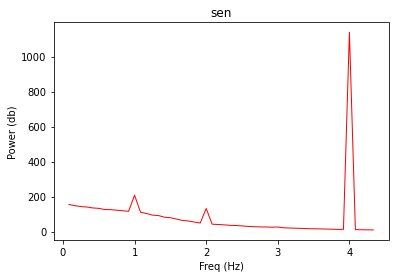

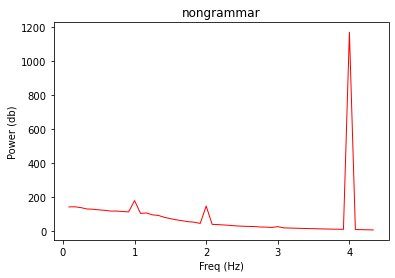

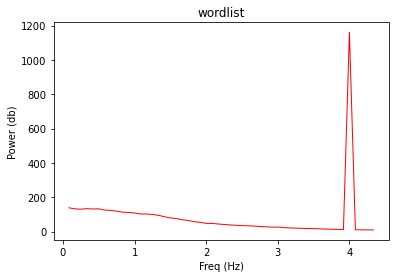

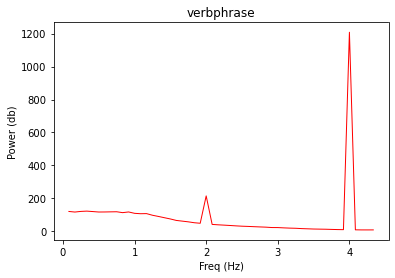

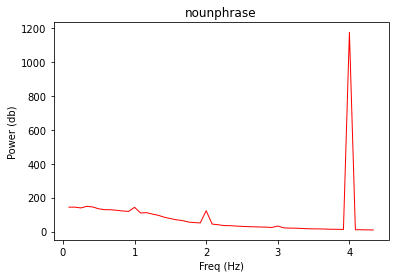

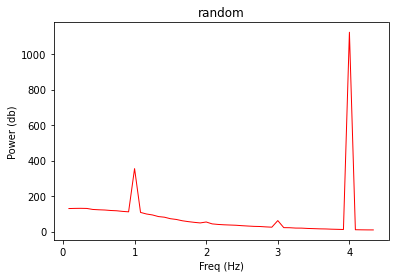

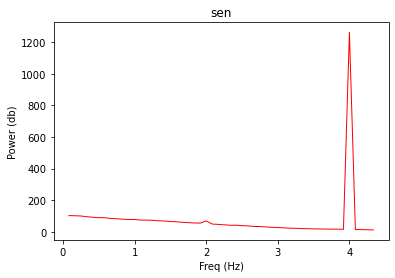

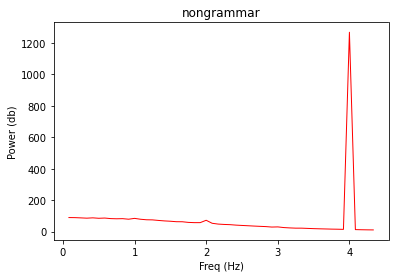

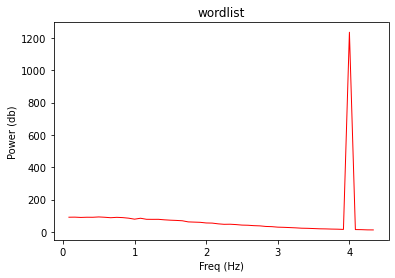

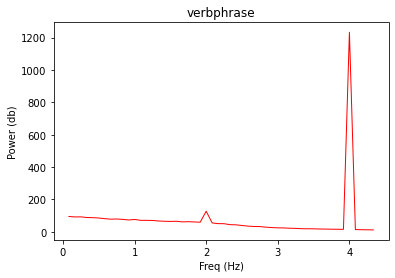

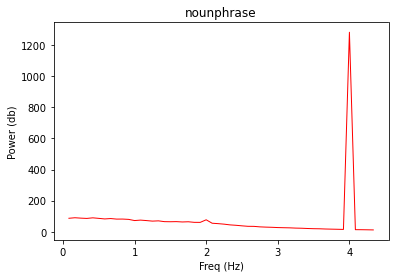

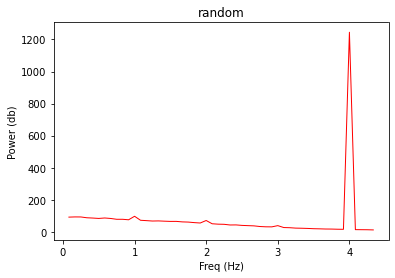

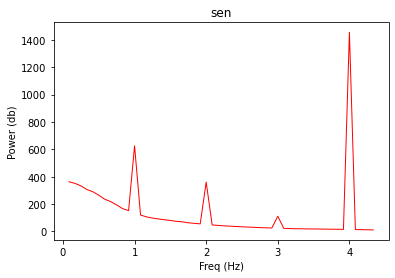

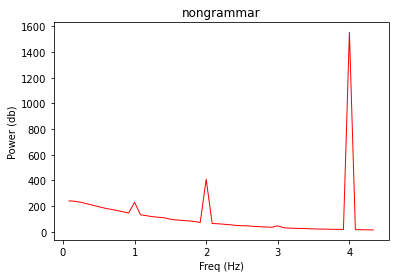

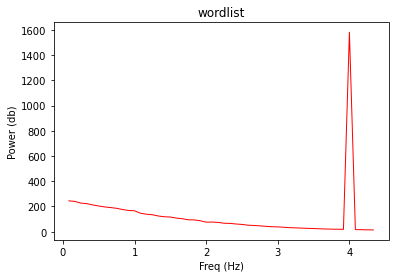

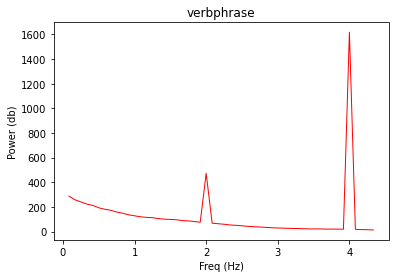

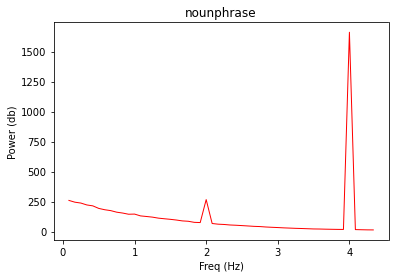

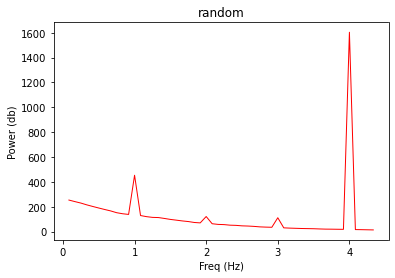

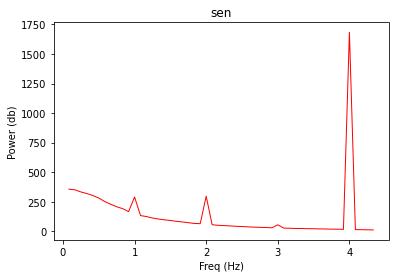

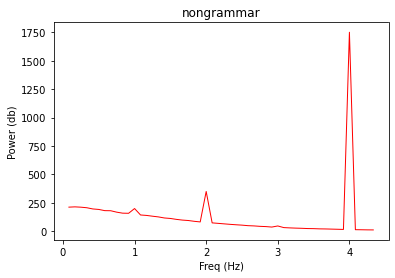

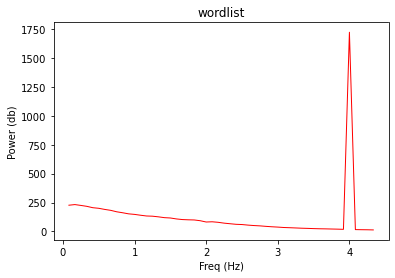

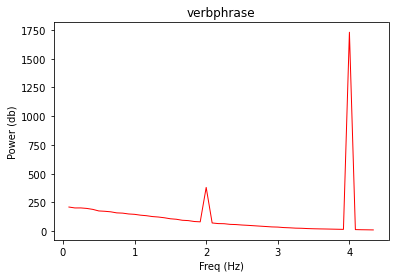

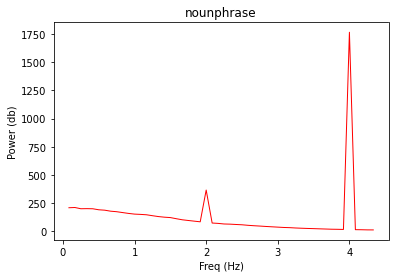

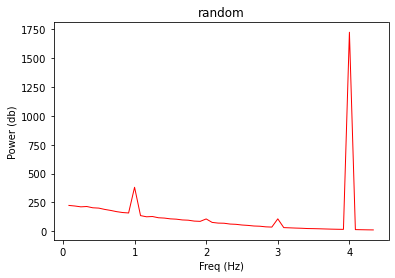

In [15]:
types_embeddings = ['one_hot','pretrained']
with_ends = [True, False]
sim_types = ['sen','nongrammar','wordlist','verbphrase','nounphrase','random']
for type_embedding in types_embeddings:
    for with_end in with_ends:
        TYPE_EMBEDDING, WITHEND = type_embedding, with_end
        time_steps = 240
        if with_end:
            if type_embedding == 'one_hot':
                model = load_model(str(Path(os.getcwd()).parent) + '\\Data\\models\\with_end_lags_one_hot.h5')
                plot_path = str(Path(os.getcwd()).parent) + '\\Data\\plots-new-datagen\\with_end_one_hot'
                np_save_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals-new-datagen\\with_end_one_hot'
            else:
                model = load_model(str(Path(os.getcwd()).parent) + '\\Data\\models\\with_end_lags_pretrained.h5')
                plot_path = str(Path(os.getcwd()).parent) + '\\Data\\plots-new-datagen\\with_end_pretrained'
                np_save_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals-new-datagen\\with_end_pretrained'
        else:    
            if type_embedding == 'one_hot':
                model = load_model(str(Path(os.getcwd()).parent) + '\\Data\\models\\without_end_lags_one_hot.h5')
                plot_path = str(Path(os.getcwd()).parent) + '\\Data\\plots-new-datagen\\without_end_one_hot'
                np_save_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals-new-datagen\\without_end_one_hot'
            else:
                model = load_model(str(Path(os.getcwd()).parent) + '\\Data\\models\\without_end_lags_pretrained.h5')
                plot_path = str(Path(os.getcwd()).parent) + '\\Data\\plots-new-datagen\\without_end_pretrained'
                np_save_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals-new-datagen\\without_end_pretrained'
        
        for sim_type in sim_types:
            train_data_gen = simulation_data(SenType = sim_type,withend=with_end,type_embedding=type_embedding)
            train_data = next(train_data_gen)[0]
            lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
            lstm_outputs = lstm_model.predict_on_batch(train_data)
            np.save(np_save_path + '_' + sim_type, lstm_outputs)
            all_mean_ps = []
            for samples in range(lstm_outputs.shape[0]):
                activation = lstm_outputs[samples,:,:]
                freq,mean_ps,unit_ps = power_spectra(activation,sampling_rate=20)
                #mean_ps = windowed_zscores(vals=mean_ps,window=50)
                all_mean_ps.append(mean_ps)
            all_mean_ps = np.array(all_mean_ps)
            all_mean_ps = np.mean(all_mean_ps,axis=0)
            #all_mean_ps = windowed_zscores(vals=all_mean_ps,window=50)
            #embedded_inputs = np.reshape(train_data,(train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
            plot_results(plot_path + '_' + sim_type, freq,power=all_mean_ps, 
                         sampling_rate=20,n_samples=train_data.shape[0],title=sim_type)